# Pitch Quality Grouped

# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Preprocessing](#Preprocessing)
    - [Multicolinearity - VIF](#Multicolinearity---VIF)
- [Analysis](#Analysis)
    - [Run Value by Event](#Run-Value-for-Ball-in-Play-by-Events)
    - [Run Value by Count](#Run-Value-by-Count)
    - [Avg Run Value by Pitch Type](#Average-Run-Value-by-Pitch-Type)
- [Fastball](#Fastball-Analysis)
    - [Fastball xQual](#Fastball-Leaders)
    - [Fastball HB & VB](#Fastball-HB-&-VB)
- [Breaking Ball Analysis](#Breaking-Ball-Analysis)
    - [Breaking Ball xQual](#Breaking-Ball-Leaders)
    - [Breaking Ball HB & VB](#Breaking-Ball-HB-&-VB)
- [Off-Speed Analysis](#Off-Speed-Analysis)
    - [Off-Speed xQual](#Off-Speed-Leaders)
    - [Off-Speed HB & VB](#Off-Speed-HB-&-VB)

# Imports

In [1]:
from sklearn.preprocessing import scale, StandardScaler
from matplotlib.patches import Rectangle
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches-rv.csv', index_col = [0])
data.drop(columns = ['plate_x', 'release_pos_x'], inplace = True)
data.rename(columns = {'pfx_-x': 'pfx_x', 
                       'plate_-x': 'plate_x', 
                       'release_pos_-x': 'release_pos_x'}, 
            inplace = True)

xrv = pd.read_csv('../data/xrv-pitches.csv', index_col = [0])
rv_pitches = pd.read_csv('../data/pitches-rv-table.csv', index_col = [0])
xrv_grouped = pd.read_csv('../data/xrv_grouped.csv', index_col = [0])

pd.set_option('max_columns', None)
print(xrv.shape)
xrv.head()

(680883, 15)


,player_name,p_throws,pitch_type,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,arm_angle,slot,release_extension,rv,n_pitches,xRV
0,"Gsellman, Robert",R,FF,93.4,1999.0,8.16,10.68,1.71,5.85,28.8,1,6.3,0.017,1,0.01969
1,"Martin, Chris",R,FF,95.3,2252.0,3.24,13.56,2.58,6.42,40.1,3,6.7,-0.053,1,0.03446
2,"Martin, Chris",R,FF,94.9,2224.0,9.00,14.16,2.71,6.38,40.1,3,6.6,-0.214,1,-0.12472
3,"Hembree, Heath",R,FF,93.5,2419.0,12.12,17.28,0.45,5.87,20.1,1,6.7,-0.245,1,-0.14789
4,"Hembree, Heath",R,FF,95.5,2516.0,12.48,18.24,0.55,5.91,20.1,1,6.6,-0.034,1,0.01774


In [3]:
print(rv_pitches.shape)
rv_pitches.head()

(3346, 14)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,arm_angle,slot,release_extension,RV,RV/100,xRV,xRV/100
0,"Abbott, Cory",R,FF,207.0,92.6,9.6,17.2,43.3,2.0,6.2,4.3,2.1,4.3,2.1
1,"Abreu, Albert",R,FF,103.0,97.8,11.7,15.4,40.8,3.0,6.4,-2.4,-2.3,-3.2,-3.1
2,"Abreu, Bryan",R,FF,310.0,95.7,8.0,17.1,28.7,1.0,6.3,-4.1,-1.3,-7.4,-2.4
3,"Acevedo, Domingo",R,FF,88.0,92.9,12.2,15.1,31.0,1.0,5.8,1.6,1.8,1.4,1.6
4,"Adam, Jason",R,FF,125.0,93.8,7.0,16.8,34.5,1.0,6.7,1.8,1.4,-2.1,-1.7


In [4]:
print(xrv_grouped.shape)
xrv_grouped.head()

(705396, 20)


,player_name,p_throws,pitch_type,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv,FF_count,SI_count,FC_count,xRV,CU_count,SL_count,KC_count,CH_count,FS_count
0,"Gsellman, Robert",R,SI,94.3,1982.0,16.20,10.56,1.20,6.05,6.5,-0.245,0.0,1.0,0.0,-0.18110,0.0,0.0,0.0,0.0,0.0
1,"Gsellman, Robert",R,SI,94.3,1930.0,18.24,5.88,1.29,6.02,6.4,-0.047,0.0,1.0,0.0,-0.07872,0.0,0.0,0.0,0.0,0.0
2,"Gsellman, Robert",R,SI,94.2,2102.0,17.04,6.36,1.41,5.88,6.4,-0.034,0.0,1.0,0.0,-0.03703,0.0,0.0,0.0,0.0,0.0
3,"Gsellman, Robert",R,SI,94.1,2033.0,15.36,4.32,1.31,5.96,6.4,-0.135,0.0,1.0,0.0,-0.04820,0.0,0.0,0.0,0.0,0.0
4,"Gsellman, Robert",R,SI,93.6,2019.0,15.48,6.96,1.42,5.89,6.5,-0.135,0.0,1.0,0.0,-0.06808,0.0,0.0,0.0,0.0,0.0


# Preprocessing

In [5]:
ff = rv_pitches.loc[(rv_pitches['pitch_type'] == 'FF') & (rv_pitches['n_pitches'] > 100)]
fc = rv_pitches.loc[(rv_pitches['pitch_type'] == 'FC') & (rv_pitches['n_pitches'] > 100)]
si = rv_pitches.loc[(rv_pitches['pitch_type'] == 'SI') & (rv_pitches['n_pitches'] > 100)]
sl = rv_pitches.loc[(rv_pitches['pitch_type'] == 'SL') & (rv_pitches['n_pitches'] > 100)]
cu = rv_pitches.loc[(rv_pitches['pitch_type'] == 'CU') & (rv_pitches['n_pitches'] > 100)]
ch = rv_pitches.loc[(rv_pitches['pitch_type'] == 'CH') & (rv_pitches['n_pitches'] > 100)]

#ff_stats = xrv.loc[xrv['pitch_type'] == 'FF']
#fc_stats = xrv.loc[xrv['pitch_type'] == 'FC']
#si_stats = xrv.loc[xrv['pitch_type'] == 'SI']
#sl_stats = xrv.loc[xrv['pitch_type'] == 'SL']
#cu_stats = xrv.loc[xrv['pitch_type'] == 'CU']
#ch_stats = xrv.loc[xrv['pitch_type'] == 'CH']

fb = xrv_grouped[xrv_grouped['pitch_type'].isin(['FF', 'FC', 'SI'])]
bb = xrv_grouped[xrv_grouped['pitch_type'].isin(['SL', 'CU', 'KC'])]
os = xrv_grouped[xrv_grouped['pitch_type'].isin(['CH', 'FS'])]

### Multicolinearity - VIF

**Independent Variables:** Velocity, Spin Rate, VB, HB, Release Extension, Horizontal Release Position, Vertical Release Position, Horizontal Plate Coords, Vertical Plate Coords

**Dependent Variable:** rv

In [6]:
features = data[['player_name', 'p_throws', 'pitch_type', 'velo', 'spin_rate', 
                 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'arm_angle',
                 'release_extension', 'rv']]

features_vif = features.select_dtypes([np.number])
vif_data = pd.DataFrame()
vif_data["feature"] = features_vif.columns

vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
                   for i in range(len(features_vif.columns))]

print(vif_data.sort_values(by = 'VIF'))

             feature         VIF
8                 rv    1.011820
2              pfx_x    1.381995
4      release_pos_x    2.456688
3              pfx_z    3.112930
6          arm_angle    8.860496
1          spin_rate   50.640764
5      release_pos_z  127.152933
7  release_extension  162.940014
0               velo  298.874018


# Analysis

### Run Value for Ball in Play by Events

In [7]:
data.groupby(['events'], as_index = False)['re24', 'lin_weight_above_outs', 
                                           'lin_weights_above_outs_scale', 'rv'].mean()

,events,re24,lin_weight_above_outs,lin_weights_above_outs_scale,rv
0,double,0.770147,1.041,1.259,0.692604
1,field_error,0.445453,0.716,0.866,0.361452
2,field_out,-0.271404,0.000,0.000,-0.372342
3,hit_by_pitch,0.359255,0.630,0.762,0.407971
4,home_run,1.385794,1.657,2.003,1.312059
5,single,0.474625,0.746,0.902,0.393770
6,triple,1.062984,1.334,1.613,0.985045
7,walk,0.332291,0.603,0.729,0.507749


### Run Value by Count

In [8]:
data.groupby(['pitch_count'], as_index = False)['woba', 'wraa_change', 'rv'].mean()

,pitch_count,woba,wraa_change,rv
0,0-0,0.314,-0.009615,-0.001308
1,0-1,0.265,-0.018637,-0.011327
2,0-2,0.197,-0.067643,-0.116486
3,1-0,0.356,-0.008226,0.001337
4,1-1,0.300,-0.021004,-0.008173
...,...,...,...,...
7,2-1,0.357,-0.018046,-0.003310
8,2-2,0.269,-0.105299,-0.151159
9,3-0,0.540,0.006415,0.129337
10,3-1,0.477,-0.006323,0.110551


### Average Run Value by Pitch Type

In [9]:
xrv_grouped.groupby(['pitch_type'], as_index = False, sort = False)['rv', 'xRV'].mean()

,pitch_type,rv,xRV
0,SI,-0.016802,-0.013819
1,FF,-0.024296,-0.021329
2,FC,-0.024137,-0.022059
3,SL,-0.040556,-0.039704
4,CU,-0.038081,-0.037793
5,KC,-0.042305,-0.042519
6,CH,-0.031865,-0.031407
7,FS,-0.052759,-0.049866


# Grouped Pitches

## Fastball
4-Seam, Cutter, Sinker

In [10]:
fb_r_stats = fb.loc[fb['p_throws'] == 'R']
fb_l_stats = fb.loc[fb['p_throws'] == 'L']

fb_r_avg = fb_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False, 
                              sort = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                            'release_pos_z', 'release_extension'].mean()
fb_l_avg = fb_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False, 
                              sort = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                            'release_pos_z', 'release_extension'].mean()
fb_avg = pd.concat([fb_r_avg, fb_l_avg], ignore_index = True)
fb_avg = fb_avg.round(1)
fb_avg.head(6)

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,SI,R,93.4,2143.9,14.8,9.2,5.7,6.3
1,FF,R,94.1,2283.3,7.1,16.1,5.9,6.4
2,FC,R,89.5,2422.6,-3.0,7.9,5.9,6.3
3,FF,L,92.8,2249.4,-7.5,16.2,6.0,6.3
4,SI,L,92.1,2077.2,-15.0,9.3,5.8,6.3
5,FC,L,86.8,2267.2,1.7,7.9,5.8,6.2


In [11]:
fb[['rv', 'xRV']].describe()

,rv,xRV
count,406250.000000,406250.000000
mean,-0.022264,-0.019396
std,0.275709,0.156572
min,-1.920000,-1.357910
25%,-0.060000,-0.060340
50%,-0.034000,-0.021940
75%,0.028000,0.017670
max,3.726000,2.385490


### Fastball xQual Leaders

In [12]:
fb['RV/100'] = round(((fb['rv'] / (fb['FF_count'] + fb['SI_count'] + fb['FC_count'])) * 100), 2)
fb['xRV/100'] = round(((fb['xRV'] / (fb['FF_count'] + fb['SI_count'] + fb['FC_count'])) * 100), 2)

cols = list(fb[['rv', 'xRV', 'RV/100', 'xRV/100']])
fb[cols]

for col in cols:
    col_zscore = col + '_zscore'
    fb[col_zscore] = ((fb[col] - fb[col].mean()) / fb[col].std(ddof = 0) * -1)

stats = fb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                   as_index = False)['FF_count', 'SI_count', 'FC_count', 'rv', 'xRV', 
                                     'rv_zscore', 'xRV_zscore'].sum()
fb = pd.merge(fb, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
fb['Qual'] = fb['rv_zscore_y'] + 100
fb['xQual'] = fb['xRV_zscore_y'] + 100
fb_r_stats = fb.loc[fb['p_throws'] == 'R']
fb_l_stats = fb.loc[fb['p_throws'] == 'L']

group_stats = fb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                         as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 
                                           'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, group_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'FF_count', 'SI_count', 'FC_count',
                                 'velo', 'pfx_x', 'pfx_z', 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])

fb_leaders = stats.sort_values(by = ['xQual'], ascending = False)
fb_leaders.head(10)

,player_name,p_throws,pitch_type,FF_count,SI_count,FC_count,velo,pfx_x,pfx_z,rv,RV/100,Qual,xRV,xRV/100,xQual
269,"Cole, Gerrit",R,FF,1397.0,0.0,0.0,97.67,11.99,17.96,-61.21,-4.38,209.21,-74.89,-5.36,405.23
1116,"Ray, Robbie",L,FF,1864.0,0.0,0.0,94.78,-8.18,17.13,-82.44,-4.42,248.47,-80.73,-4.33,384.69
1225,"Scherzer, Max",R,FF,1316.0,0.0,0.0,94.30,10.61,16.03,-57.00,-4.33,200.47,-62.96,-4.78,339.11
1158,"Rogers, Trevor",L,FF,1249.0,0.0,0.0,94.55,-11.07,14.80,-54.71,-4.38,197.58,-57.25,-4.58,310.92
1494,"Woodruff, Brandon",R,FF,940.0,0.0,0.0,96.52,6.35,16.64,-54.18,-5.76,220.60,-50.95,-5.42,308.96
1460,"Wheeler, Zack",R,FF,1353.0,0.0,0.0,97.17,7.65,15.91,-63.86,-4.72,222.38,-58.67,-4.34,307.10
1534,"deGrom, Jacob",R,FF,704.0,0.0,0.0,99.21,9.07,16.45,-40.22,-5.71,189.02,-43.07,-6.12,287.86
1154,"Rodón, Carlos",L,FF,1302.0,0.0,0.0,95.36,-7.94,17.55,-60.01,-4.61,212.52,-53.81,-4.13,282.38
923,"Montas, Frankie",R,FF,877.0,0.0,0.0,96.42,7.00,17.42,-40.37,-4.60,175.60,-43.42,-4.95,268.65
783,"Loáisiga, Jonathan",R,SI,0.0,595.0,0.0,98.31,15.60,11.78,-34.07,-5.73,175.52,-37.20,-6.25,263.88


In [13]:
fb[['Qual', 'xQual']].describe()

,Qual,xQual
count,406250.000000,406250.000000
mean,108.135061,111.960345
std,40.450615,68.278010
min,-38.549554,-144.118902
25%,83.319741,73.082620
50%,100.516652,99.804128
75%,129.738931,141.566852
max,248.472710,405.229876


### RHP Fastball HB & VB xQual

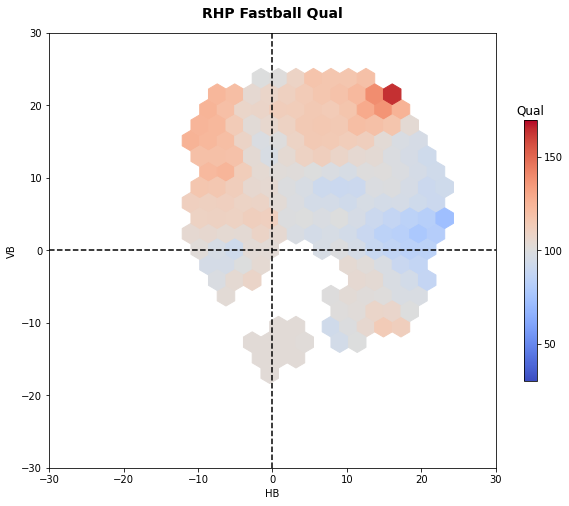

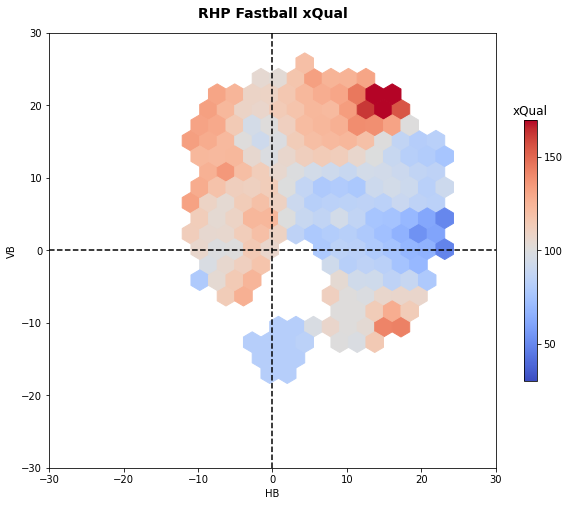

In [14]:
plt.figure(figsize = (10, 8))
plt.hexbin(fb_r_stats['pfx_x'], fb_r_stats['pfx_z'], C = fb_r_stats['Qual'], 
           cmap = 'coolwarm', mincnt = 15, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(fb_r_stats['pfx_x'], fb_r_stats['pfx_z'], C = fb_r_stats['xQual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball xQual', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Fastball HB & VB xQual

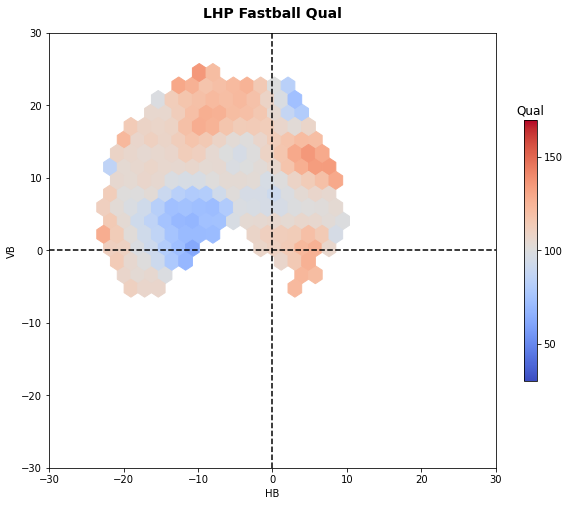

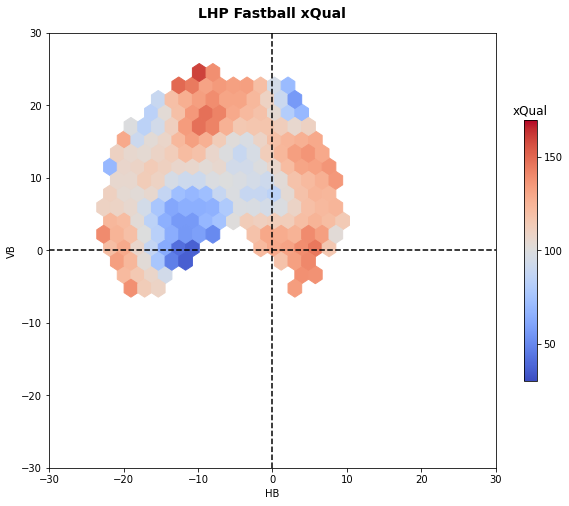

In [15]:
plt.figure(figsize = (10, 8))
plt.hexbin(fb_l_stats['pfx_x'], fb_l_stats['pfx_z'], C = fb_l_stats['Qual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(fb_l_stats['pfx_x'], fb_l_stats['pfx_z'], C = fb_l_stats['xQual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball xQual', fontsize = 14, fontweight = 'bold', pad = 15);

If we have a negative z-score the corresponding raw score should be less than the mean, and a positive z-score must correspond to a raw score higher than the mean.

## Breaking Ball
Slider, Curveball, Knuckle Curve

In [16]:
bb_r_stats = bb.loc[bb['p_throws'] == 'R']
bb_l_stats = bb.loc[bb['p_throws'] == 'L']

bb_r_avg = bb_r_stats.groupby(['pitch_type', 'p_throws'], 
                                          as_index = False, 
                                          sort = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                        'release_pos_z', 'release_extension'].mean()
bb_l_avg = bb_l_stats.groupby(['pitch_type', 'p_throws'], 
                                          as_index = False, 
                                          sort = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                        'release_pos_z', 'release_extension'].mean()
bb_avg = pd.concat([bb_r_avg, bb_l_avg], ignore_index = True)
bb_avg = bb_avg.round(1)
bb_avg.head(6)

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,SL,R,84.9,2438.2,-6.3,1.8,5.8,6.3
1,CU,R,79.2,2538.3,-9.6,-9.3,6.0,6.2
2,KC,R,81.5,2575.8,-8.3,-11.7,5.9,6.3
3,SL,L,83.9,2357.1,5.8,1.5,5.9,6.2
4,CU,L,77.7,2439.9,8.4,-7.5,6.0,6.1
5,KC,L,78.9,2310.0,5.0,-9.0,6.3,6.0


In [17]:
bb[['rv', 'xRV']].describe()

,rv,xRV
count,207975.000000,207975.000000
mean,-0.039972,-0.039349
std,0.271374,0.154497
min,-2.012000,-1.150280
25%,-0.060000,-0.076650
50%,-0.034000,-0.031470
75%,0.028000,0.006810
max,3.707000,2.380330


## Breaking Ball Leaders

In [18]:
bb['RV/100'] = round(((bb['rv'] / (bb['CU_count'] + bb['SL_count'] + bb['KC_count'])) * 100), 2)
bb['xRV/100'] = round(((bb['xRV'] / (bb['CU_count'] + bb['SL_count'] + bb['KC_count'])) * 100), 2)

cols = list(bb[['rv', 'xRV', 'RV/100', 'xRV/100']])
bb[cols]

for col in cols:
    col_zscore = col + '_zscore'
    bb[col_zscore] = ((bb[col] - bb[col].mean())/ bb[col].std(ddof=0) * -1)

stats = bb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['SL_count', 'CU_count', 'KC_count', 
                                         'rv', 'xRV', 'rv_zscore', 'xRV_zscore'].sum()
bb = pd.merge(bb, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
bb['Qual'] = bb['rv_zscore_y'] + 100
bb['xQual'] = bb['xRV_zscore_y'] + 100
bb_r_stats = bb.loc[bb['p_throws'] == 'R']
bb_l_stats = bb.loc[bb['p_throws'] == 'L']

q_stats = bb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                 as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 
                                                   'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'SL_count', 'CU_count', 'KC_count',
                                 'velo', 'pfx_x', 'pfx_z', 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])

bb_leaders = stats.sort_values(by = ['xQual'], ascending = False)
bb_leaders.head(10)

,player_name,p_throws,pitch_type,SL_count,CU_count,KC_count,velo,pfx_x,pfx_z,rv,RV/100,Qual,xRV,xRV/100,xQual
928,"Rodón, Carlos",L,SL,603.0,0.0,0.0,85.76,8.21,-1.06,-49.04,-8.13,191.89,-54.26,-9.00,297.61
1126,"Urías, Julio",L,CU,0.0,952.0,0.0,81.38,15.78,-0.93,-61.65,-6.48,186.94,-62.19,-6.53,260.09
690,"McClanahan, Shane",L,SL,674.0,0.0,0.0,89.15,3.79,2.03,-40.05,-5.94,148.31,-50.82,-7.54,257.30
761,"Morton, Charlie",R,CU,0.0,1095.0,0.0,80.64,-16.57,-10.06,-71.97,-6.57,203.91,-65.69,-6.00,246.32
1221,"deGrom, Jacob",R,SL,409.0,0.0,0.0,91.57,-4.67,3.46,-35.96,-8.79,172.29,-36.50,-8.92,232.08
766,"Musgrove, Joe",R,SL,815.0,0.0,0.0,84.07,-14.03,-1.56,-52.88,-6.49,174.83,-52.46,-6.44,231.95
935,"Rogers, Tyler",R,SL,479.0,0.0,0.0,71.76,-13.14,13.84,-39.56,-8.26,175.24,-38.97,-8.14,230.26
555,"Kershaw, Clayton",L,SL,859.0,0.0,0.0,87.07,4.71,8.18,-51.09,-5.95,161.73,-53.23,-6.20,225.77
1030,"Smyly, Drew",L,CU,0.0,897.0,0.0,78.86,-2.95,-0.17,-43.59,-4.86,128.52,-53.81,-6.00,219.82
96,"Berríos, José",R,CU,0.0,927.0,0.0,82.93,-15.04,-3.52,-50.21,-5.42,148.47,-54.81,-5.91,218.67


In [19]:
bb[['Qual', 'xQual']].describe()

,Qual,xQual
count,207975.000000,207975.000000
mean,105.455172,109.249028
std,27.791856,47.577906
min,30.597978,-10.982709
25%,88.216391,82.011277
50%,101.537877,101.275741
75%,119.989300,131.785678
max,203.909284,297.605604


### RHP Breaking Ball HB & VB

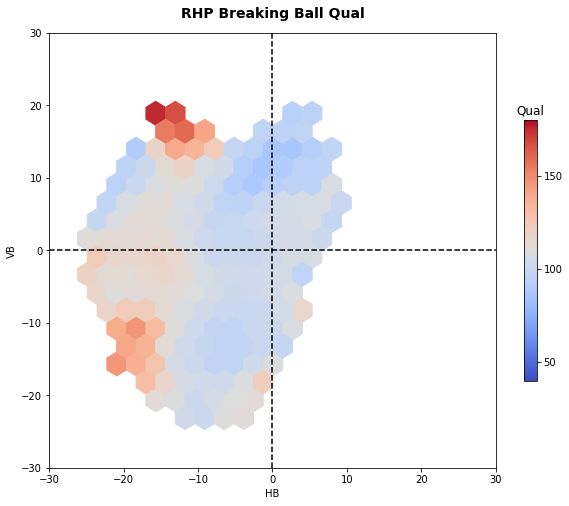

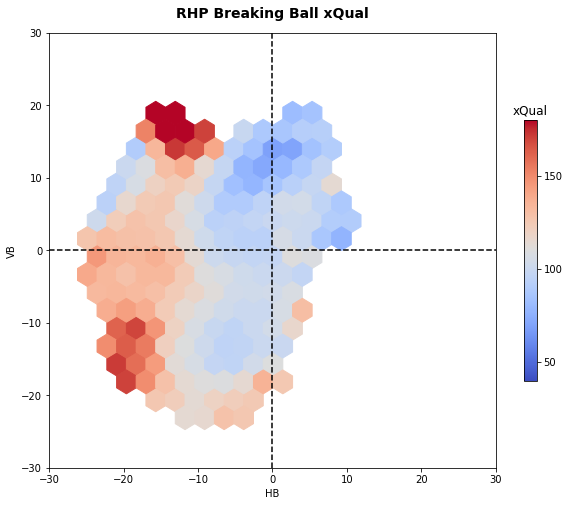

In [20]:
plt.figure(figsize = (10, 8))
plt.hexbin(bb_r_stats['pfx_x'], bb_r_stats['pfx_z'], C = bb_r_stats['Qual'], 
           cmap = 'coolwarm', mincnt = 15, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(bb_r_stats['pfx_x'], bb_r_stats['pfx_z'], C = bb_r_stats['xQual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball xQual', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Breaking Ball HB & VB

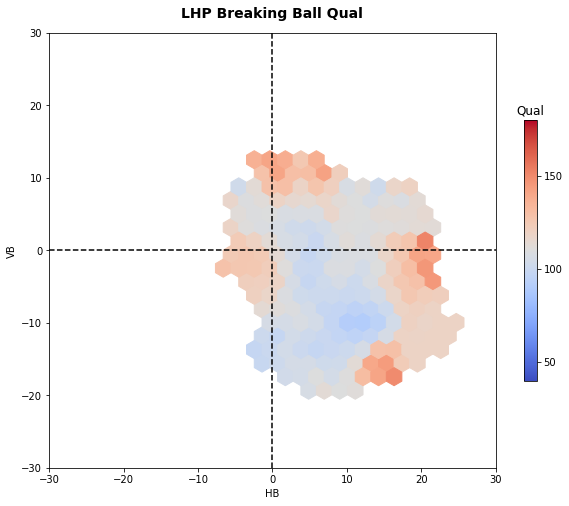

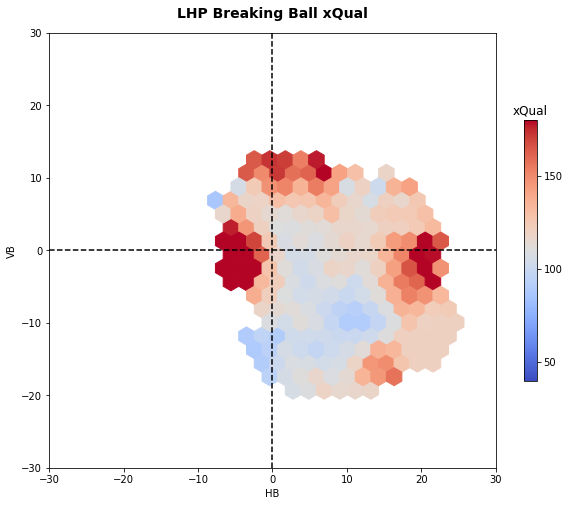

In [21]:
plt.figure(figsize = (10, 8))
plt.hexbin(bb_l_stats['pfx_x'], bb_l_stats['pfx_z'], C = bb_l_stats['Qual'], 
           cmap = 'coolwarm', mincnt = 15, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Breaking Ball Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(bb_l_stats['pfx_x'], bb_l_stats['pfx_z'], C = bb_l_stats['xQual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Breaking Ball xQual', fontsize = 14, fontweight = 'bold', pad = 15);

## Off-Speed
Changeup, Splitter

In [22]:
os_r_stats = os.loc[os['p_throws'] == 'R']
os_l_stats = os.loc[os['p_throws'] == 'L']

os_r_avg = os_r_stats.groupby(['pitch_type', 'p_throws'], 
                                          as_index = False, 
                                          sort = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                        'release_pos_z', 'release_extension'].mean()
os_l_avg = os_l_stats.groupby(['pitch_type', 'p_throws'], 
                                          as_index = False, 
                                          sort = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                        'release_pos_z', 'release_extension'].mean()
os_avg = pd.concat([os_r_avg, os_l_avg], ignore_index = True)
os_avg = os_avg.round(1)
os_avg.head(6)

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,CH,R,85.5,1756.8,13.8,6.3,5.8,6.3
1,FS,R,85.8,1384.0,10.7,3.9,5.9,6.3
2,CH,L,83.6,1737.4,-13.9,7.8,5.8,6.2
3,FS,L,83.8,1039.1,-8.7,4.0,5.8,6.6


In [23]:
os[['rv', 'xRV']].describe()

,rv,xRV
count,91171.000000,91171.000000
mean,-0.034349,-0.033602
std,0.278526,0.158253
min,-1.904000,-1.128850
25%,-0.067000,-0.077050
50%,-0.034000,-0.028270
75%,0.032000,0.013200
max,3.306000,2.214050


### Off-Speed Leaders

In [24]:
os['RV/100'] = round(((os['rv'] / (os['CH_count'] + os['FS_count'])) * 100), 2)
os['xRV/100'] = round(((os['xRV'] / (os['CH_count'] + os['FS_count'])) * 100), 2)

cols = list(os[['rv', 'xRV', 'RV/100', 'xRV/100']])
os[cols]

for col in cols:
    col_zscore = col + '_zscore'
    os[col_zscore] = ((os[col] - os[col].mean()) / os[col].std(ddof=0) * -1)

stats = os.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['CH_count', 'FS_count', 'rv', 'xRV', 
                                         'rv_zscore', 'xRV_zscore'].sum()
os = pd.merge(os, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
os['Qual'] = os['rv_zscore_y'] + 100
os['xQual'] = os['xRV_zscore_y'] + 100
os_r_stats = os.loc[os['p_throws'] == 'R']
os_l_stats = os.loc[os['p_throws'] == 'L']

q_stats = os.groupby(['player_name', 'p_throws', 'pitch_type'], 
                     as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 
                                       'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'CH_count', 'FS_count', 'velo', 
                                 'pfx_x', 'pfx_z', 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])

os_leaders = stats.sort_values(by = ['xQual'], ascending = False)
os_leaders.head(10)

,player_name,p_throws,pitch_type,CH_count,FS_count,velo,pfx_x,pfx_z,rv,RV/100,Qual,xRV,xRV/100,xQual
235,"Gausman, Kevin",R,FS,0.0,1044.0,83.60,12.35,2.20,-81.94,-7.85,265.43,-73.33,-7.02,341.73
105,"Castillo, Luis",R,CH,952.0,0.0,88.33,16.77,0.94,-52.99,-5.57,172.86,-59.30,-6.23,272.58
432,"Montas, Frankie",R,FS,0.0,677.0,87.49,11.52,3.82,-47.20,-6.97,185.97,-48.93,-7.23,265.44
403,"Matz, Steven",L,CH,598.0,0.0,85.05,-15.94,3.27,-35.79,-5.99,154.75,-45.89,-7.67,263.01
466,"Ohtani, Shohei",R,FS,0.0,366.0,88.15,4.88,2.41,-40.27,-11.00,199.44,-36.39,-9.94,252.25
485,"Peralta, Wily",R,FS,0.0,352.0,81.27,10.16,6.67,-33.77,-9.59,177.84,-35.28,-10.02,248.22
392,"Manaea, Sean",L,CH,723.0,0.0,84.53,-12.18,6.67,-39.20,-5.42,151.56,-45.12,-6.24,231.58
441,"Morgan, Eli",R,CH,322.0,0.0,74.81,14.74,4.89,-22.63,-7.03,141.55,-28.98,-9.00,214.76
683,"Williams, Devin",R,CH,621.0,0.0,83.72,16.96,-4.16,-35.35,-5.69,150.35,-36.00,-5.80,195.66
612,"Suarez, José",L,CH,449.0,0.0,82.30,-7.79,8.61,-29.40,-6.55,150.19,-28.58,-6.36,185.24


In [25]:
os[['Qual', 'xQual']].describe()

,Qual,xQual
count,91171.000000,91171.000000
mean,108.053679,113.227903
std,30.627166,51.660526
min,44.740873,1.031175
25%,90.909469,83.813051
50%,100.882315,102.226536
75%,119.140569,129.993355
max,265.430519,341.732907


### RHP Off-Speed HB & VB

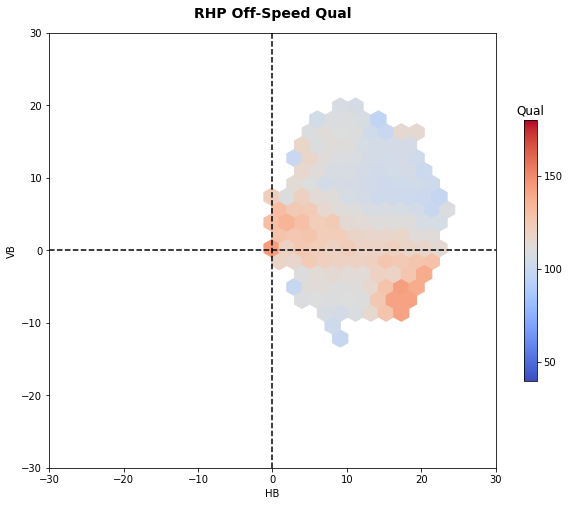

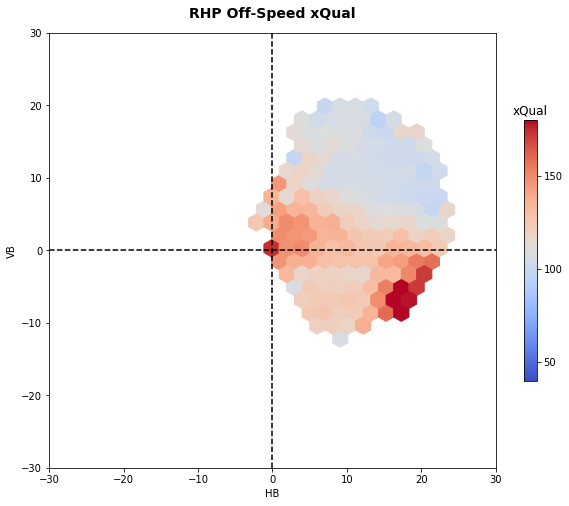

In [26]:
plt.figure(figsize = (10, 8))
plt.hexbin(os_r_stats['pfx_x'], os_r_stats['pfx_z'], C = os_r_stats['Qual'], 
           cmap = 'coolwarm', mincnt = 15, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Off-Speed Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(os_r_stats['pfx_x'], os_r_stats['pfx_z'], C = os_r_stats['xQual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Off-Speed xQual', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Off-Speed HB & VB

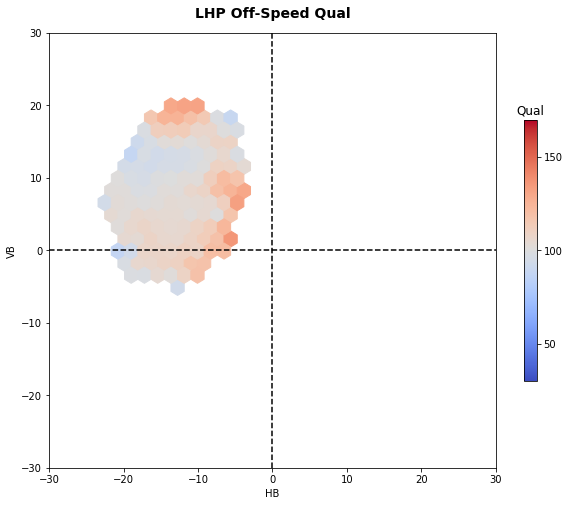

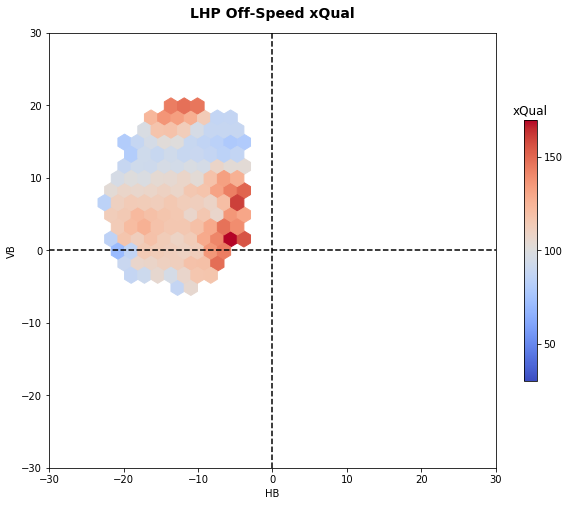

In [27]:
plt.figure(figsize = (10, 8))
plt.hexbin(os_l_stats['pfx_x'], os_l_stats['pfx_z'], C = os_l_stats['Qual'], 
           cmap = 'coolwarm', mincnt = 15, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Off-Speed Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(os_l_stats['pfx_x'], os_l_stats['pfx_z'], C = os_l_stats['xQual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Off-Speed xQual', fontsize = 14, fontweight = 'bold', pad = 15);